In [172]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime


df = pd.read_csv("/content/elon_musk_tweets.csv")

df['date'] = pd.to_datetime(df['date'])

df = df.sort_values(by='date')

scaler = MinMaxScaler(feature_range=(0, 1))
df[['user_followers']] = scaler.fit_transform(
    df[['user_followers']]
)

df.set_index(['date'], inplace=True)


In [173]:
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_numeric_columns)
print(df.dtypes)

Non-numeric columns: Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_verified', 'text', 'hashtags', 'source', 'is_retweet'],
      dtype='object')
id                    int64
user_name            object
user_location        object
user_description     object
user_created         object
user_followers      float64
user_friends          int64
user_favourites       int64
user_verified          bool
text                 object
hashtags             object
source               object
retweets              int64
favorites             int64
is_retweet             bool
dtype: object


In [174]:
df = df.drop(columns=non_numeric_columns)
df = df.drop(columns='id')
df = df.drop(columns='user_friends')
df = df.drop(columns='user_favourites')
df = df.drop(columns='retweets')
df = df.drop(columns='favorites')

In [175]:
df = df.fillna(0)


In [176]:
df = df.astype(float)

In [177]:
print(df.dtypes)

user_followers    float64
dtype: object


In [178]:
data = df['user_followers'].values
print(len(data))
data = data.reshape(-1, 1)
print(data)

5904
[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.99999872]
 [0.99999872]
 [0.99999872]]


In [181]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length=500):
        self.sequence_length = sequence_length
        self.data = data.values

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        # Используем numpy срезы
        x = self.data[idx: idx + self.sequence_length, :]
        y = self.data[idx + self.sequence_length, :]
        return torch.FloatTensor(x), torch.FloatTensor(y)

# Подготовка данных
dataset = TimeSeriesDataset(df, sequence_length=500)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [182]:
class BRITSModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BRITSModel, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Для двунаправленного LSTM

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), hidden_dim).to(x.device)  # Двунаправленный LSTM
        c0 = torch.zeros(2, x.size(0), hidden_dim).to(x.device)

        out, _ = self.rnn(x, (h0, c0))  # Пропускаем данные через LSTM
        out = self.fc(out[:, -1, :])    # Используем последний выход для прогноза
        return out


In [183]:

sequence_length = 500  # Длина последовательности для обучения модели (например, количество временных шагов, которые модель будет учитывать)
input_dim = 1  # Размерность входных данных (1, так как мы работаем с одномерными данными)
hidden_dim = 64  # Размерность скрытого слоя модели (определяет количество нейронов в скрытых слоях)
output_dim = input_dim  # Размерность выходных данных (та же, что и входных, т.к. мы прогнозируем те же данные)
num_epochs = 10
batch_size = 32
learning_rate = 0.001  # Скорость обучения (определяет, насколько сильно обновляются веса при каждом шаге)

dataset = TimeSeriesDataset(df, sequence_length)  # Создаем объект набора данных, где df - исходный DataFrame, а sequence_length - длина последовательности для входа в модель
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  # Создаем DataLoader, который будет подавать данные батчами, случайно перемешивая их

model = BRITSModel(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss() # Mean Square Error
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(num_epochs):
    for x_batch, y_batch in dataloader:
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

torch.save(model.state_dict(), 'brits_model.pth')

Epoch [1/10], Loss: 0.0003
Epoch [2/10], Loss: 0.0002
Epoch [3/10], Loss: 0.0002
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000


<ipython-input-200-8f06db3afebc>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/brits_model.pth'))


5904
145175827
145175893
145175963
145176028
145176098
145176169
145176234
145176299
145176369
145176429
145176500
145176560
145176625
145176690
145176756
145176821
145176881
145176946
145177006
145177072
145177132
145177192
145177252
145177317
145177373
145177433
145177498
145177553
145177613
145177669
145177729
145177789
145177844
145177904
145177965
145178015
145178075
145178125
145178185
145178241
145178296
145178351
145178406
145178461
145178511
145178567
145178617
145178672
145178727
145178777
145178828
145178878
145178928
145178978
145179028
145179078
145179134
145179184
145179234
145179279
145179329
145179379
145179430
145179480
145179525
145179570
145179620
145179665
145179710
145179761
145179801
145179846
145179891
145179941
145179986
145180027
145180072
145180117
145180162
145180202
145180247
145180287
145180333
145180373
145180423
145180463
145180503
145180543
145180583
145180629
145180669
145180709
145180749
145180789
145180829
145180869
145180905
145180950
145180985
14518

<ipython-input-200-8f06db3afebc>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(int(value))


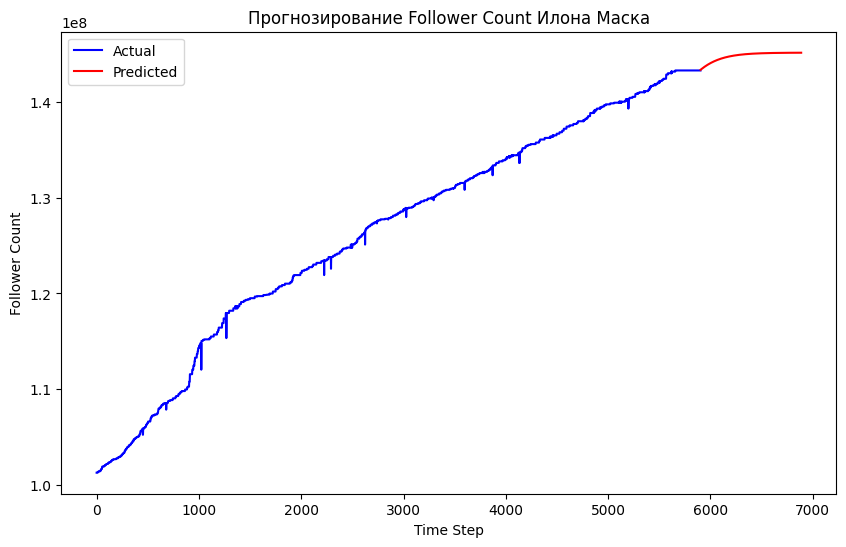

In [200]:
import matplotlib.pyplot as plt
import torch

# Подгружаем обученную модель
model = BRITSModel(input_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load('/content/brits_model.pth'))
model.eval()  # Переводим модель в режим инференса (оценки)

# Выбираем только одну метрику для прогнозирования - Retweet Count
follower_count_data = df['user_followers'].values  # Данные только по метрике Retweet Count
# Подготовим последние sequence_length данных для прогнозирования
input_data = follower_count_data[-sequence_length:]  # Используем последние данные
input_data = torch.FloatTensor(input_data).unsqueeze(0).unsqueeze(2)  # (1, sequence_length, 1)

# Сделаем прогноз для следующих N шагов (например, для 10 шагов)
trend_growth_factor = 1.0
forecast_steps = 984
predicted_values = []

# Прогнозируем по одному шагу за раз
for _ in range(forecast_steps):
    with torch.no_grad():  # Нет необходимости в вычислении градиентов для прогноза
        prediction = model(input_data)  # Прогнозируем следующий шаг
        predicted_values.append(prediction.numpy().flatten()[0] * trend_growth_factor)  # Добавляем предсказанное значение в список

    # Обновляем input_data для следующего шага
    # Берем последние sequence_length - 1 значений и добавляем предсказанное значение
    new_input = prediction.unsqueeze(0)  # Сделаем из предсказания тензор формы (1, 1, 1)
    input_data = torch.cat([input_data[:, 1:, :], new_input], dim=1)  # Обновляем входные данные

input_data_rescaled = scaler.inverse_transform(np.array(follower_count_data).reshape(-1, 1))
predicted_values_rescaled = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))
print(len(input_data_rescaled))
for value in predicted_values_rescaled[-100:]:
  print(int(value))

# Визуализация:
plt.figure(figsize=(10, 6))

# Исходные данные для последнего шага (Followers Count)
plt.plot(range(len(input_data_rescaled)), input_data_rescaled, label='Actual', color='blue')

# Прогнозируемые значения (следующие шаги)
plt.plot(range(len(follower_count_data), len(follower_count_data) + forecast_steps), predicted_values_rescaled, label='Predicted', color='red')

plt.xlabel('Time Step')
plt.ylabel('Follower Count')
plt.title('Прогнозирование Follower Count Илона Маска')

plt.legend()

plt.show()


18 авг. 2023 г. — The average number of followers for all 153 million accounts

101240855 - старт, 143325985 - финиш, то есть примерно 42 миллиона подписчиков за год, учитывая внешние обстоятельства. Всего 5904 записи, то есть примерно 492 в месяц. Предсказание - прирост в 2 миллиона примерно за два месяца. Меньше ожидаемого, но на графике видны сильные падения, влияющие на итоговый результат. Ровной линии нет.